# **Classification whether the data is audio , video or text from a common box of mixed items **

In [ ]:
# ==== UNIDENTIFIED BOX → classify files by modality (text/audio/video/image/doc/unknown) ====
# NO routing, NO models — just file classification (+ .eml attachments)

# System + Python deps (safe for Colab)
!apt-get -y -qq install libmagic1 >/dev/null
!pip -q install python-magic pandas tqdm

import os, mimetypes, hashlib, magic, pandas as pd
from tqdm import tqdm
from email import policy
from email.parser import BytesParser

# --------- CONFIG ---------
# Your generic “box” (put any files in here); also include your processed folders for convenience.
BOX_DIR   = "/content/box"  # change if you want
TEXT_DIR  = "/content/email_phishing_dataset"
AUDIO_DIR = "/content/deepfake_audio_dataset"
VIDEO_DIR = "/content/deepfake_video_dataset"

SEARCH_ROOTS = [p for p in [BOX_DIR, TEXT_DIR, AUDIO_DIR, VIDEO_DIR] if os.path.exists(p)]
OUT_CSV = "/content/drive/MyDrive/processed/classify_manifest.csv"

# --------- MIME → modality helpers ---------
MAGIC = magic.Magic(mime=True)

EXT_MAP = {
    # text
    ".txt":"text",".csv":"text",".json":"text",".md":"text",".html":"text",".htm":"text",".eml":"text",
    # audio
    ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
    # video
    ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
    # image
    ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
    # docs
    ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

def modality_from_mime(mime: str) -> str:
    if not mime: return "unknown"
    major = mime.split("/")[0]
    if major in ("audio","video","image","text"):
        return major
    if mime == "application/pdf": return "doc"
    if mime.startswith("application/vnd") or mime.startswith("application/ms"):
        return "doc"
    return "unknown"

def sha256_file(path, chunk=65536, cap=100*1024*1024):
    try:
        size = os.path.getsize(path)
        if size is None or size > cap:
            return None
        h = hashlib.sha256()
        with open(path, "rb") as f:
            while True:
                b = f.read(chunk)
                if not b: break
                h.update(b)
        return h.hexdigest()
    except Exception:
        return None

def classify_file(path: str):
    ext = os.path.splitext(path)[1].lower()
    size = None
    try: size = os.path.getsize(path)
    except Exception: pass

    # MIME sniff with libmagic → fallback to mimetypes
    try:
        mime = MAGIC.from_file(path)
    except Exception:
        mime = mimetypes.guess_type(path)[0]

    modality = modality_from_mime(mime)
    if modality == "unknown":
        modality = EXT_MAP.get(ext, "unknown")

    return {
        "path": path,
        "filename": os.path.basename(path),
        "ext": ext,
        "mime": mime,
        "modality": modality,
        "size_bytes": size,
        "sha256": sha256_file(path),
        "is_attachment": False,
        "parent": None,
    }

def attachments_from_eml(eml_path: str):
    """Parse .eml and classify attachments as separate rows (virtual paths)."""
    rows = []
    try:
        with open(eml_path, "rb") as f:
            msg = BytesParser(policy=policy.default).parse(f)
        for part in msg.walk():
            if part.is_attachment():
                fname = part.get_filename() or "attachment"
                ctype = part.get_content_type()
                payload = part.get_payload(decode=True) or b""
                mod = modality_from_mime(ctype)
                rows.append({
                    "path": eml_path + f"::attachment::{fname}",
                    "filename": fname,
                    "ext": os.path.splitext(fname)[1].lower(),
                    "mime": ctype,
                    "modality": mod,
                    "size_bytes": len(payload),
                    "sha256": hashlib.sha256(payload).hexdigest() if payload else None,
                    "is_attachment": True,
                    "parent": eml_path,
                })
    except Exception:
        pass
    return rows

# --------- Walk roots & classify ---------
rows = []
for root in SEARCH_ROOTS:
    for dp, _, files in os.walk(root):
        for fn in files:
            full = os.path.join(dp, fn)
            info = classify_file(full)
            rows.append(info)
            if info["ext"] == ".eml":
                rows += attachments_from_eml(full)

df = pd.DataFrame(rows)

# Save + print summary
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Classification manifest written: {OUT_CSV}")
print(f"Rows: {len(df)}")

if not df.empty:
    print("\nCounts by modality:")
    print(df["modality"].value_counts(dropna=False))
    print("\nSample:")
    print(df[["filename","modality","ext","mime","size_bytes","is_attachment"]].head(12).to_string(index=False))


✅ Classification manifest written: /content/drive/MyDrive/processed/classify_manifest.csv
Rows: 3432

Counts by modality:
modality
video      3431
unknown       1
Name: count, dtype: int64

Sample:
                              filename modality  ext      mime  size_bytes  is_attachment
           06__podium_speech_happy.mp4    video .mp4 video/mp4     8949516          False
                   01__kitchen_pan.mp4    video .mp4 video/mp4     4330494          False
          10__talking_against_wall.mp4    video .mp4 video/mp4     5188235          False
11__outside_talking_still_laughing.mp4    video .mp4 video/mp4     7705656          False
          13__talking_against_wall.mp4    video .mp4 video/mp4     5278061          False
 20__walking_and_outside_surprised.mp4    video .mp4 video/mp4    20371057          False
  18__outside_talking_pan_laughing.mp4    video .mp4 video/mp4    11364089          False
               16__exit_phone_room.mp4    video .mp4 video/mp4     3113649        

In [ ]:
import zipfile, os, collections

DATA_DIR  = "/content/drive/MyDrive/MUFG SIH"
zips = {
  "text":  f"{DATA_DIR}/email_phishing_dataset.zip",
  "audio": f"{DATA_DIR}/Deepfake_audio.zip",
  "video": f"{DATA_DIR}/Deepfake_video.zip",
}

EXT_TO_MODALITY = {
  ".txt":"text",".csv":"text",".json":"text",".md":"text",".html":"text",".htm":"text",".eml":"text",
  ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
  ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
  ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
  ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

counts = collections.Counter()
for label, zp in zips.items():
    if not os.path.exists(zp):
        print(f"❌ missing zip: {zp}");
        continue
    with zipfile.ZipFile(zp, "r") as z:
        for name in z.namelist():
            ext = os.path.splitext(name)[1].lower()
            mod = EXT_TO_MODALITY.get(ext, None)
            if mod: counts[mod] += 1

print("ZIP-level modality counts (by extension):")
for k in ["video","audio","text","image","doc"]:
    print(f"{k:6s}: {counts.get(k,0)}")


ZIP-level modality counts (by extension):
video : 3431
audio : 169754
text  : 7
image : 0
doc   : 0


In [ ]:
import os
print("TEXT_DIR exists?", os.path.exists("/content/email_phishing_dataset"))
print("AUDIO_DIR exists?", os.path.exists("/content/deepfake_audio_dataset"))
print("VIDEO_DIR exists?", os.path.exists("/content/deepfake_video_dataset"))


TEXT_DIR exists? True
AUDIO_DIR exists? True
VIDEO_DIR exists? True


In [ ]:
# --- Intake classifier for processed data: text / audio / video / image (+ .eml attachments) ---
# Installs
!pip install -q python-magic pandas tqdm

import os, re, hashlib, mimetypes, magic, pandas as pd
from tqdm import tqdm
from email import policy
from email.parser import BytesParser

# ---- CONFIG: point these to your processed/extracted folders ----
TEXT_DIR   = "/content/email_phishing_dataset"        # your extracted email/text folder
AUDIO_DIR  = "/content/deepfake_audio_dataset"        # your extracted audio dataset
VIDEO_DIR  = "/content/deepfake_video_dataset"        # your extracted video dataset
OUT_CSV    = "/content/drive/MyDrive/processed/intake_manifest.csv"

# If some are missing, it's fine; we'll just skip them
roots = [p for p in [TEXT_DIR, AUDIO_DIR, VIDEO_DIR] if os.path.exists(p)]

# ---- helpers ----
MAGIC = magic.Magic(mime=True)

EXT_MAP = {
    # text-like
    ".txt":"text", ".csv":"text", ".json":"text", ".md":"text", ".html":"text", ".htm":"text", ".eml":"text",
    # audio
    ".wav":"audio",".mp3":"audio",".flac":"audio",".m4a":"audio",".ogg":"audio",".aac":"audio",".wma":"audio",
    # video
    ".mp4":"video",".mov":"video",".mkv":"video",".avi":"video",".webm":"video",".m4v":"video",
    # images (will be routed to VLM in your agent)
    ".png":"image",".jpg":"image",".jpeg":"image",".bmp":"image",".gif":"image",".webp":"image",".tiff":"image",
    # docs (optional)
    ".pdf":"doc",".doc":"doc",".docx":"doc",".ppt":"doc",".pptx":"doc",".xls":"doc",".xlsx":"doc"
}

def sha256_file(path, chunk=65536):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def modality_from_mime(mime: str) -> str:
    if not mime: return "unknown"
    major = mime.split("/")[0]
    if major in ("audio","video","image","text"):
        # treat text/* as text; image/* as image (to be handled by VLM)
        return major
    # special-cases
    if mime in ("application/pdf",): return "doc"
    if mime.startswith("application/vnd") or mime.startswith("application/ms"):
        return "doc"
    return "unknown"

def classify_path(path: str):
    """
    Returns dict with modality, mime, size, sha256. If .eml, also returns attachments (list).
    """
    try:
        size = os.path.getsize(path)
    except Exception:
        size = None

    ext = os.path.splitext(path)[1].lower()
    mime = None
    try:
        mime = MAGIC.from_file(path)
    except Exception:
        # fallback to mimetypes
        mime = mimetypes.guess_type(path)[0]

    # primary modality from MIME first, then extension map fallback
    modality = modality_from_mime(mime)
    if modality == "unknown" and ext in EXT_MAP:
        modality = EXT_MAP[ext]

    # hash (avoid hashing >100MB to keep quick)
    sha = None
    if size is not None and size <= 100 * 1024 * 1024:
        try: sha = sha256_file(path)
        except Exception: sha = None

    out = {
        "path": path,
        "rel_path": None,
        "filename": os.path.basename(path),
        "ext": ext,
        "mime": mime,
        "modality": modality,
        "size_bytes": size,
        "sha256": sha,
        "is_attachment": False,
        "parent_id": None,
        "group_key": None,
    }

    # handle .eml: parse & classify attachments (metadata only)
    attachments = []
    if ext == ".eml" and os.path.getsize(path) > 0:
        try:
            with open(path, "rb") as f:
                msg = BytesParser(policy=policy.default).parse(f)
            for part in msg.walk():
                if part.is_attachment():
                    fname = part.get_filename() or "attachment"
                    ctype = part.get_content_type()  # e.g., audio/mpeg
                    mod = modality_from_mime(ctype)
                    payload = part.get_payload(decode=True) or b""
                    att_sha = hashlib.sha256(payload).hexdigest() if payload else None
                    att_size = len(payload)
                    attachments.append({
                        "path": path + f"::attachment::{fname}",
                        "rel_path": None,
                        "filename": fname,
                        "ext": os.path.splitext(fname)[1].lower(),
                        "mime": ctype,
                        "modality": mod,
                        "size_bytes": att_size,
                        "sha256": att_sha,
                        "is_attachment": True,
                        "parent_id": sha or path,  # link back to email
                        "group_key": None,
                    })
        except Exception:
            pass

    return out, attachments

def make_group_key(p: str) -> str:
    """
    Group parallel data by base filename (without extension) or trailing id in path.
    Useful when email/audio/video share a common stem.
    """
    name = os.path.basename(p)
    stem = os.path.splitext(name)[0]
    # normalize common separators
    stem = re.sub(r"[\s\-]+", "_", stem.lower())
    return stem

# ---- walk all roots and classify ----
rows = []
for root in roots:
    for dp, _, files in os.walk(root):
        for fn in files:
            full = os.path.join(dp, fn)
            item, atts = classify_path(full)
            item["rel_path"] = os.path.relpath(full, root)
            item["group_key"] = make_group_key(full)
            rows.append(item)
            # add attachments (for .eml)
            for att in atts:
                att["rel_path"] = None
                att["group_key"] = make_group_key(item["filename"])
                rows.append(att)

df = pd.DataFrame(rows)

# small cleanups
if not df.empty:
    # map 'image' to 'image' modality explicitly (you’ll likely route images to VLM)
    # ensure modality is one of: text/audio/video/image/doc/unknown
    allowed = {"text","audio","video","image","doc","unknown"}
    df["modality"] = df["modality"].apply(lambda m: m if m in allowed else "unknown")

# write manifest
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
print(f"✅ Intake manifest written: {OUT_CSV}")
print(f"Rows: {len(df)}")
if not df.empty:
    print(df.head(8))
    print("\nCounts by modality:\n", df["modality"].value_counts(dropna=False))


✅ Intake manifest written: /content/drive/MyDrive/processed/intake_manifest.csv
Rows: 164153
                                                path  \
0  /content/email_phishing_dataset/Nigerian_Fraud...   
1          /content/email_phishing_dataset/Enron.csv   
2        /content/email_phishing_dataset/Nazario.csv   
3  /content/email_phishing_dataset/phishing_email...   
4        /content/email_phishing_dataset/CEAS_08.csv   
5    /content/email_phishing_dataset/SpamAssasin.csv   
6           /content/email_phishing_dataset/Ling.csv   
7  /content/deepfake_audio_dataset/for-original/f...   

                                            rel_path            filename  \
0                                 Nigerian_Fraud.csv  Nigerian_Fraud.csv   
1                                          Enron.csv           Enron.csv   
2                                        Nazario.csv         Nazario.csv   
3                                 phishing_email.csv  phishing_email.csv   
4                     

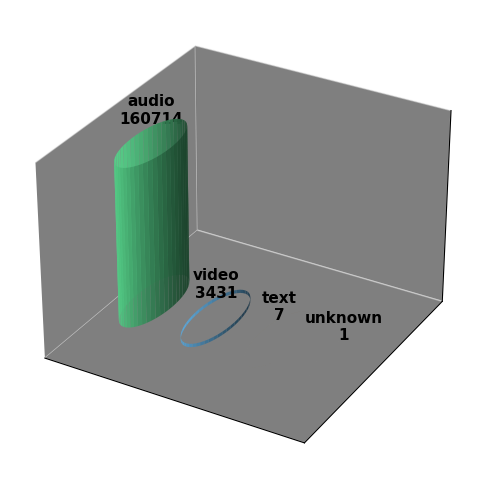

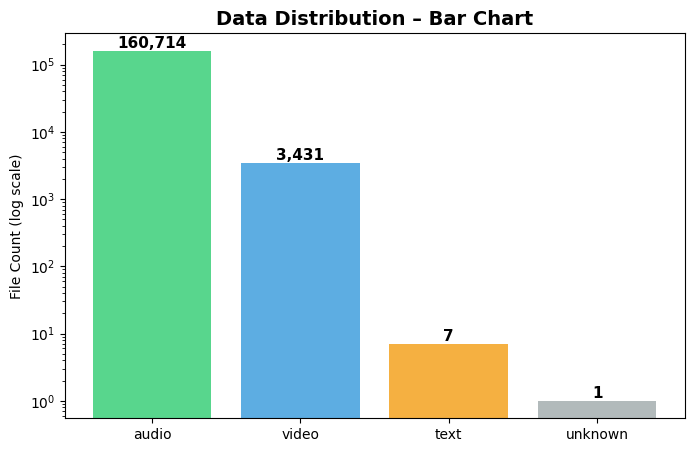

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Load manifest ---
MANIFEST = "/content/drive/MyDrive/processed/intake_manifest.csv"
df = pd.read_csv(MANIFEST)
counts = df["modality"].value_counts().to_dict()

# Ensure fixed ordering
BINS = ["audio", "video", "text", "unknown"]
counts = {k: counts.get(k, 0) for k in BINS}

# =======================
# 1. Cylinders (3D containers)
# =======================
def draw_cylinder(ax, x0, y0, r, h, color):
    theta = np.linspace(0, 2*np.pi, 50)
    z = np.linspace(0, h, 2)
    theta_grid, z_grid = np.meshgrid(theta, z)
    X = r*np.cos(theta_grid) + x0
    Y = r*np.sin(theta_grid) + y0
    ax.plot_surface(X, Y, z_grid, linewidth=0, antialiased=True,
                    shade=True, color=color, alpha=0.95)

heights = {k: (v / max(counts.values())) * 5 for k,v in counts.items()}
x_positions = np.arange(len(BINS)) * 2.0
colors = ["#58D68D","#5DADE2","#F5B041","#B2BABB"]

fig = plt.figure(figsize=(10,6), facecolor='none')
ax = fig.add_subplot(111, projection='3d', facecolor='none')

for i, key in enumerate(BINS):
    draw_cylinder(ax, x_positions[i], 0, 0.6, heights[key], colors[i])
    ax.text(x_positions[i], 0, heights[key]+0.5,
            f"{key}\n{counts[key]}",
            ha='center', va='bottom', fontsize=11, weight='bold')

ax.set_xlim(-1, x_positions[-1]+1)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(0, 6)
ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
ax.grid(False)
ax.xaxis.pane.set_facecolor((0,0,0,0))
ax.yaxis.pane.set_facecolor((0,0,0,0))
ax.zaxis.pane.set_facecolor((0,0,0,0))


# =======================
# 2. 2D Bar Chart
# =======================
plt.figure(figsize=(8,5))
bars = plt.bar(counts.keys(), counts.values(), color=colors)
plt.bar_label(bars, labels=[f"{v:,}" for v in counts.values()], fontsize=11, weight="bold")
plt.yscale("log")  # optional: log scale, helps show imbalance
plt.title("Data Distribution – Bar Chart", fontsize=14, weight="bold")
plt.ylabel("File Count (log scale)")
plt.show()
